`サポートベクターマシン`分類と回帰どちらにも使える協力かつ柔軟な教師ありアルゴリズム

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 5.7.1 サポートベクターマシンの必要性

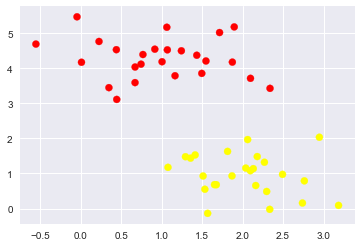

In [2]:
#分類のための単純なデータの作成
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

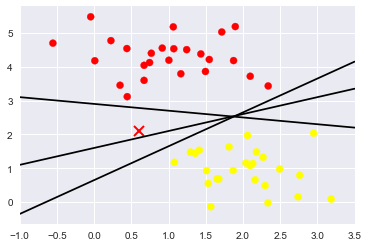

In [3]:
#3つの線形種別分類
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
    
plt.xlim(-1, 3.5);

## 5.7.2 サポートベクターマシン：マージンの最大化

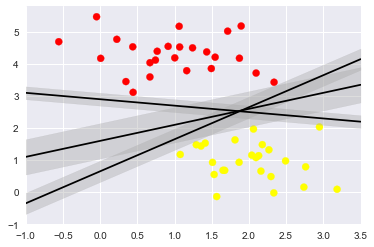

In [4]:
#クラスの間に幅が0の線を描画するのではなく、ある幅のマージンをとる
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

``マージン最大化``サポートベクターマシンでは、このマージンを最大にする線が最適モデルとして選択される。

### 5.7.2.1 サポートベクターマシンへの当てはめ

In [5]:
#線形カーネルを使用
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

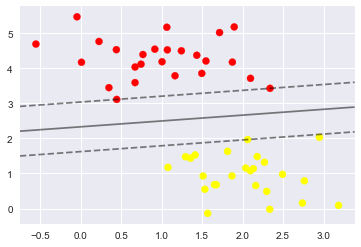

In [7]:
#マージン：点線、サポートベクター：線が通っている点
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [8]:
#サポートベクターのポイントを確認
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

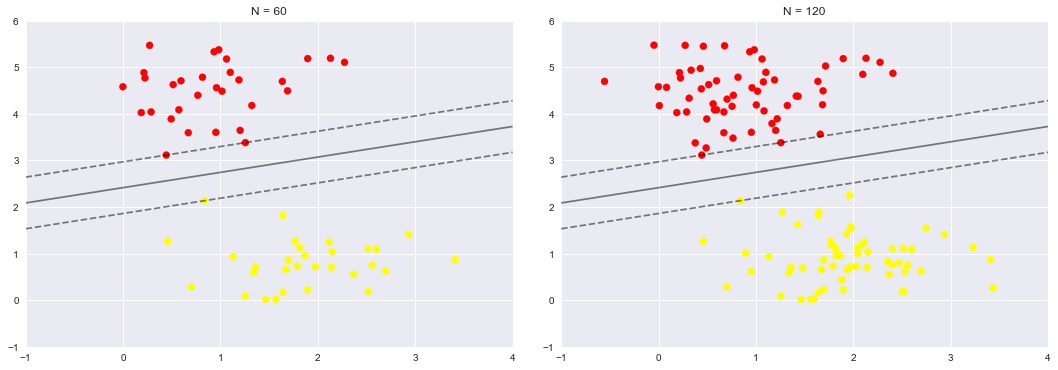

In [9]:
#SVMモデルに対する新しい学習ポイントの影響
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In [10]:
#対話型SVM可視化
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget-interact',))

### 5.7.2.2 線形には分類できないデータ：カーネルSVM

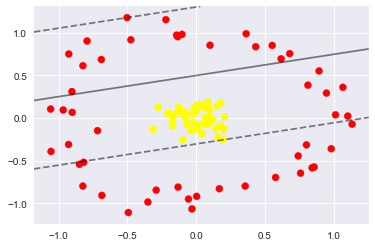

In [11]:
#非線形境界に対して十分に機能しない線形分類器
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [12]:
#放射基底関数を使用
r = np.exp(-(X ** 2).sum(1))

In [13]:
#三番目の次元を追加し可視化
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[30, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(30, 90), value=30), IntSlider(value=30, description='azim', max=90, min=-30), Output()), _dom_classes=('widget-interact',))

- `カーネル変換` 2転換の類似性関係（またはカーネル）に基づいた基底関数変換
- `カーネルトリック` カーネル変換の完全なN次元表現を構築することなく、カーネル変換されたデータの適合を暗黙的に行う

In [14]:
#kernelハイパーパラメータkernelをrbf(放射基底関数(radial basis function))に
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

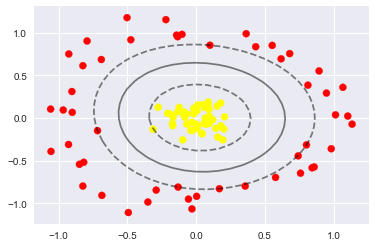

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none');

### 5.7.2.3 SVMのチューニング：ソフトマージン

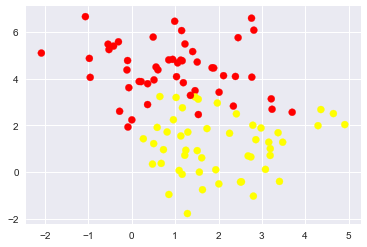

In [16]:
#重なりのあるデータサンプルを生成
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

`チューニングパラメータ(c)`
- 非常に大きい：マージン博多区、ポイントはマージンの中に入らない
- 小さい：マージンは柔らかく、いくつかの点を包含して広げることが可能

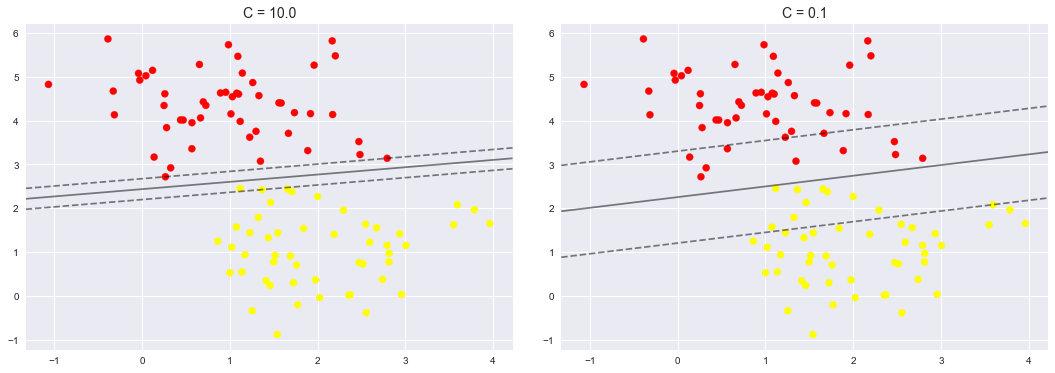

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

## 5.7.3 事例：顔認識

In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Junichiro Koizumi' 'Tony Blair']
(1277, 62, 47)


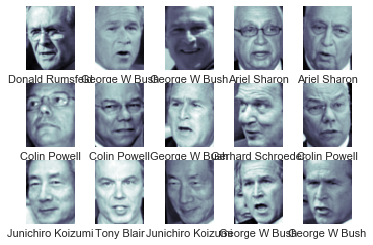

In [21]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [25]:
#前処理（主成分分析）により基本成分を抽出した後、サポートベクターマシン分類器に与える
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [26]:
#データを学習データとテストセットに分類
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [28]:
#交差検証のグリッド検索を使用してパラメータの組み合わせを調べる
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 33.9 s, sys: 1.49 s, total: 35.4 s
Wall time: 16.7 s
{'svc__C': 5, 'svc__gamma': 0.001}


In [29]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

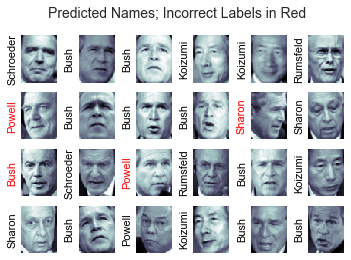

In [31]:
#モデルにより予測したラベル
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [33]:
#リカバリ統計情報により推定器のパフォーマンスを把握
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.54      0.50        13
     Colin Powell       0.74      0.85      0.79        66
  Donald Rumsfeld       0.83      0.63      0.72        30
    George W Bush       0.93      0.90      0.91       139
Gerhard Schroeder       0.86      0.79      0.83        24
Junichiro Koizumi       0.89      0.94      0.91        17
       Tony Blair       0.81      0.81      0.81        31

      avg / total       0.84      0.83      0.84       320



Text(92.68,0.5,'predicted label')

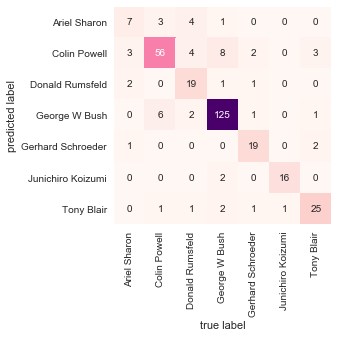

In [36]:
#クラス間の混合行列を確認
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='RdPu', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

## 5.7.4 サポートベクターマシンまとめ

 <利点>
 - 比較的少数のサポートベクターに依存した手法であり、コンパクトなモデル（＝メモリ消費が少ない）
 - 学習を済ませてしまえば、モデルを使用した予測は非常に高速
 - マージン付近の点だけが影響を持つため、サンプルよりも高い次元のデータに対してもうまく機能する
 - カーネル法との統合により非常に高い汎用性をもつ

<欠点>
- サンプル数Nの場合、最悪では$O[N^2]$, 効率的な実装では$O[N^3]$の計算量が必要になる
- 結果はソフトマージンのパラメータCの選択に強い影響を受ける
- 結果は直接的な確率的解釈を持たない。`内部交差検証`(SVCのprobabilityパラメータ）によって推定できるが、コストはかかる。